In [1]:
!pip install segmentation_models_pytorch

In [2]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
import rasterio
import glob
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch

In [8]:
dataset_path_tmn = "/kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Taman Mini"
number_to_load_tmn = ['417712', '417713', '417714', '417715', '417716', '417717', '417718', '417719']

dataset_path_rgn = "/kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Ragunan-data"
number_to_load_rgn = ['208840', '208841', '208842', '208843']

images_paths = []
masks_paths = []

for numb_name in number_to_load_tmn:
    images_dir = os.path.join(dataset_path_tmn, 'image', numb_name)
    masks_dir = os.path.join(dataset_path_tmn, 'mask', numb_name)
    if os.path.isdir(images_dir) and os.path.isdir(masks_dir):
        image_path = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.tif')])
        mask_path = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.tif')])
        
        images_paths.extend(image_path)
        masks_paths.extend(mask_path)

for numb_name in number_to_load_rgn:
    images_dir = os.path.join(dataset_path_rgn, 'image', numb_name)
    masks_dir = os.path.join(dataset_path_rgn, 'mask', numb_name)
    if os.path.isdir(images_dir) and os.path.isdir(masks_dir):
        image_path = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.tif')])
        mask_path = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith('.tif')])
        
        images_paths.extend(image_path)
        masks_paths.extend(mask_path)

In [9]:
from sklearn.model_selection import train_test_split

image_train, image_test, mask_train, mask_test = train_test_split(
    images_paths, masks_paths, test_size = 0.2, random_state = 42 
)

image_test, image_val, mask_test, mask_val = train_test_split(
    image_test, mask_test, test_size = 0.5, random_state = 42 
)

In [10]:
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([ 
    A.HorizontalFlip(p = 0.5),
    A.RandomBrightnessContrast(p = 0.2),
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)), 
    ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)), 
    ToTensorV2()
])

val_transform = A.Compose([
    A.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)), 
    ToTensorV2()
])

class SegmentDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform = None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform 

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"))
        mask = (mask > 127).astype(np.uint8)

        if self.transform:
            augmented = self.transform(image = image, mask = mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask, image_path, mask_path

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [11]:
train_dataset = SegmentDataset(image_train, mask_train, transform = train_transform)
test_dataset = SegmentDataset(image_test, mask_test, transform = test_transform)
val_dataset = SegmentDataset(image_val, mask_val, transform = val_transform)

In [12]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Train size: 105
Validation size: 14
Test size: 13


In [13]:
image, mask, img_path, mask_path = train_dataset[0]
print(image)
print(image.shape)

tensor([[[-1.0904, -0.5253, -1.3302,  ..., -0.4911, -0.4226, -0.1828],
         [-0.5596, -0.7137, -0.6623,  ..., -0.4568, -0.3027, -0.2342],
         [-0.9877, -0.9192, -0.9363,  ..., -0.4739, -0.2856, -0.3541],
         ...,
         [-0.2684, -0.2856, -0.5938,  ..., -1.2103, -1.0733, -1.3130],
         [-0.3883, -0.5424, -0.4397,  ..., -1.0733, -0.9363, -1.8097],
         [-1.1932, -1.4329, -1.8268,  ..., -1.8953, -1.2959, -1.4329]],

        [[-0.6877, -0.1099, -0.9153,  ..., -0.3901, -0.3901, -0.1450],
         [-0.1450, -0.3025, -0.2325,  ..., -0.3550, -0.2325, -0.1625],
         [-0.5826, -0.5126, -0.5126,  ..., -0.3025, -0.1450, -0.2500],
         ...,
         [ 0.4153,  0.4503,  0.2052,  ..., -0.9153, -0.7927, -1.0203],
         [ 0.3627,  0.2577,  0.4153,  ..., -0.7927, -0.6527, -1.5455],
         [-0.4076, -0.6352, -0.9678,  ..., -1.6331, -1.0378, -1.1604]],

        [[-0.7936, -0.2184, -1.0724,  ..., -0.4798, -0.4973, -0.2532],
         [-0.2532, -0.4101, -0.3927,  ..., -0

In [14]:
print(mask)
print(mask.shape)

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 0],
        ...,
        [1, 0, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 1]], dtype=torch.uint8)
torch.Size([256, 256])


In [15]:
image_test, mask_test, img_path_test, mask_path_test = test_dataset[0]
print(image_test)
print(image_test.shape)

tensor([[[-0.0287, -0.1657,  0.0056,  ...,  0.0569,  0.6906,  0.2453],
         [ 0.0056, -0.1314, -0.0458,  ...,  1.6495,  1.6153,  0.0398],
         [ 0.0398, -0.0287,  0.0569,  ...,  1.5297,  1.4612,  0.0741],
         ...,
         [ 1.0159,  0.9646,  0.7248,  ...,  0.1768,  0.9817,  1.2899],
         [ 0.9988,  1.2214,  0.9988,  ...,  0.2624,  0.7933,  0.7591],
         [ 1.2043,  1.2214,  1.1187,  ...,  0.4337,  0.5193,  1.1015]],

        [[ 0.3277,  0.1877,  0.3452,  ...,  0.3627,  0.9230,  0.4853],
         [ 0.3452,  0.2052,  0.2927,  ...,  1.9384,  1.8683,  0.2752],
         [ 0.3452,  0.2752,  0.3627,  ...,  1.8158,  1.7108,  0.2577],
         ...,
         [ 0.6254,  0.6254,  0.4328,  ..., -0.0574,  0.8179,  1.1681],
         [ 0.4328,  0.7129,  0.5903,  ...,  0.0126,  0.5728,  0.5903],
         [ 0.5553,  0.6429,  0.6078,  ...,  0.1877,  0.2752,  0.9055]],

        [[ 0.3742,  0.2348,  0.3916,  ...,  0.4265,  1.0191,  0.5311],
         [ 0.3916,  0.2522,  0.3393,  ...,  2

In [16]:
print(mask_test)
print(mask_test.shape)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
torch.Size([256, 256])


In [17]:
train_loader = DataLoader(train_dataset, batch_size = 4, pin_memory = False, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 4, pin_memory = False, shuffle = False, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 4, pin_memory = False, shuffle = False, num_workers = 4)

In [18]:
for img, msk, img_path, mask_path in train_loader:
    print("image shape:", img.shape) 
    print("mask shape:", msk.shape)

image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256]

In [19]:
for img, msk, img_path, mask_path in test_loader:
    print("image shape:", img.shape) 
    print("mask shape:", msk.shape)

image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([1, 3, 256, 256])
mask shape: torch.Size([1, 256, 256])


In [20]:
for img, msk, img_path, mask_path in val_loader:
    print("image shape:", img.shape) 
    print("mask shape:", msk.shape)

image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([4, 3, 256, 256])
mask shape: torch.Size([4, 256, 256])
image shape: torch.Size([2, 3, 256, 256])
mask shape: torch.Size([2, 256, 256])


In [21]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F

class CustomDeepLabV3(nn.Module):
    def __init__(self, encoder_name = "resnet50", encoder_weights = "imagenet", in_channels = 3, classes = 1):
        super(CustomDeepLabV3, self).__init__()
        self.base_model = smp.DeepLabV3(
            encoder_name = encoder_name,
            encoder_weights = encoder_weights,
            in_channels = in_channels,
            classes = 256, 
            activation = None
        )
        self.head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(128, classes, kernel_size = 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.head(x)
        return x

def batchnorm_to_groupnorm(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            num_features = module.num_features
            setattr(model, name, nn.GroupNorm(num_groups = 32, num_channels = num_features))
        else:
            batchnorm_to_groupnorm(module)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomDeepLabV3(encoder_name = "resnet50", encoder_weights = "imagenet", in_channels = 3, classes = 1)
model = batchnorm_to_groupnorm(model)
model.to(device)

CustomDeepLabV3(
  (base_model): DeepLabV3(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): GroupNorm(32, 256, eps=1e-05, affine=True)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

In [22]:
def calc_iou(pred, gt):
    with torch.no_grad():
        pred = (pred.sigmoid() > 0.5).long()
        pred, gt = pred.contiguous().view(-1), gt.contiguous().view(-1)

        intersect = torch.logical_and(pred > 0, gt > 0).sum().float().item()
        union = torch.logical_or(pred > 0, gt > 0).sum().float().item()
        iou = (intersect + 1e-6) / (union + 1e-6)

    return iou

In [23]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self, smooth = 1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred_mask, gt_mask):
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask = pred_mask.clamp(min = 1e-5, max = 1 - 1e-5) 
        pred_mask = pred_mask.squeeze(1) 
        gt_mask = gt_mask.squeeze(1)

        pred_mask = pred_mask.view(pred_mask.size(0), -1)
        gt_mask = gt_mask.view(gt_mask.size(0), -1).float()

        intersect = (pred_mask * gt_mask).sum(dim = 1)
        dice = (2.0 * intersect + self.smooth) / (pred_mask.sum(dim = 1) + gt_mask.sum(dim = 1) + self.smooth)
        return 1 - dice.mean()

In [24]:
class DiceBCELoss(nn.Module):
    def __init__(self, dice_weight, bce_weight):
        super(DiceBCELoss, self).__init__()
        self.dice = DiceLoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight

    def forward(self, pred_mask, gt_mask):
        pred_mask = pred_mask.squeeze(1)  
        gt_mask = gt_mask.squeeze(1).float()
        dice = self.dice(pred_mask.unsqueeze(1), gt_mask.unsqueeze(1)) 
        bce = self.bce(pred_mask, gt_mask)
        return (self.bce_weight * bce) + (self.dice_weight * dice)

In [25]:
import torch.optim as optim
from tqdm import tqdm
import warnings
from torch.optim.lr_scheduler import ReduceLROnPlateau

warnings.filterwarnings("ignore")

loss_func = DiceBCELoss(dice_weight = 0.7, bce_weight = 0.3)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3, verbose = True)

num_epoch = 25
patience = 5
trigger = 0
best_val_loss = float('inf')
best_model = None

for epoch in range(num_epoch):
    model.train()
    total_loss = 0
    total_iou = 0

    for images, masks, images_path, masks_path in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_func(outputs, masks.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += calc_iou(outputs, masks)

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)

    print(f"Epoch {epoch+1}/{num_epoch}:")
    print(f"Train loss: {avg_loss}, Train Avg IoU: {avg_iou}\n")
    
    model.eval()
    val_loss = 0
    val_total_iou = 0
    
    with torch.no_grad():
        for val_images, val_masks, val_images_path, val_masks_path in tqdm(val_loader):
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            val_output = model(val_images)
            val_loss += loss_func(val_output, val_masks.float()).item()

            val_batch_iou = calc_iou(val_output, val_masks)
            val_total_iou += val_batch_iou

    val_avg_loss = val_loss / len(val_loader)
    val_avg_iou = val_total_iou / len(val_loader)

    scheduler.step(val_avg_loss)
    
    print(f"Val loss: {val_avg_loss}, Val Avg IoU: {val_avg_iou}\n")

    if val_avg_loss < best_val_loss:
        best_val_loss = val_avg_loss
        best_model = model
        trigger = 0
    else:
        trigger += 1
    
    if trigger >= patience:
        print(f"Stop at epoch {epoch+1}")
        break

fine_tune_model = best_model

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Epoch 1/25:
Train loss: 0.5957939514407405, Train Avg IoU: 0.4127400024797023



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]


Val loss: 0.48019472509622574, Val Avg IoU: 0.4945099416705733



100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Epoch 2/25:
Train loss: 0.476810219111266, Train Avg IoU: 0.5392566695455772



100%|██████████| 4/4 [00:00<00:00,  7.26it/s]


Val loss: 0.3601280003786087, Val Avg IoU: 0.6436947714832999



100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Epoch 3/25:
Train loss: 0.39507448231732406, Train Avg IoU: 0.5996931655972494



100%|██████████| 4/4 [00:00<00:00,  7.31it/s]


Val loss: 0.294332891702652, Val Avg IoU: 0.724219627879978



100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Epoch 4/25:
Train loss: 0.3406454308165444, Train Avg IoU: 0.6542788603092433



100%|██████████| 4/4 [00:00<00:00,  7.29it/s]


Val loss: 0.2611191049218178, Val Avg IoU: 0.7525496012569336



100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Epoch 5/25:
Train loss: 0.3104091810959357, Train Avg IoU: 0.6793269153924274



100%|██████████| 4/4 [00:00<00:00,  7.34it/s]


Val loss: 0.25988324731588364, Val Avg IoU: 0.7501178125121655



100%|██████████| 27/27 [00:07<00:00,  3.59it/s]


Epoch 6/25:
Train loss: 0.3104069933847145, Train Avg IoU: 0.676799961426057



100%|██████████| 4/4 [00:00<00:00,  7.40it/s]


Val loss: 0.3004501834511757, Val Avg IoU: 0.70842774773508



100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Epoch 7/25:
Train loss: 0.3005740156880132, Train Avg IoU: 0.6892083815840411



100%|██████████| 4/4 [00:00<00:00,  7.36it/s]


Val loss: 0.23475541546940804, Val Avg IoU: 0.7733361887243198



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 8/25:
Train loss: 0.27206154940304933, Train Avg IoU: 0.7143177142777674



100%|██████████| 4/4 [00:00<00:00,  7.25it/s]


Val loss: 0.23159147053956985, Val Avg IoU: 0.7722742525214559



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 9/25:
Train loss: 0.2757588078578313, Train Avg IoU: 0.7089082627737402



100%|██████████| 4/4 [00:00<00:00,  7.17it/s]


Val loss: 0.22748225927352905, Val Avg IoU: 0.7790304372970589



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 10/25:
Train loss: 0.2634983024111501, Train Avg IoU: 0.7239991054301399



100%|██████████| 4/4 [00:00<00:00,  7.32it/s]


Val loss: 0.22296945378184319, Val Avg IoU: 0.7817266535556947



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 11/25:
Train loss: 0.2676160346578669, Train Avg IoU: 0.7168485905322493



100%|██████████| 4/4 [00:00<00:00,  7.22it/s]


Val loss: 0.21951508149504662, Val Avg IoU: 0.7847854750002916



100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Epoch 12/25:
Train loss: 0.26454228769849847, Train Avg IoU: 0.7279166605506917



100%|██████████| 4/4 [00:00<00:00,  7.26it/s]


Val loss: 0.2252347692847252, Val Avg IoU: 0.7793418044917545



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 13/25:
Train loss: 0.25701341971203134, Train Avg IoU: 0.730036482202443



100%|██████████| 4/4 [00:00<00:00,  7.37it/s]


Val loss: 0.21777719259262085, Val Avg IoU: 0.784919363677798



100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Epoch 14/25:
Train loss: 0.2500382567997332, Train Avg IoU: 0.7367263242049158



100%|██████████| 4/4 [00:00<00:00,  7.33it/s]


Val loss: 0.23345853760838509, Val Avg IoU: 0.7701880907311753



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 15/25:
Train loss: 0.260320954852634, Train Avg IoU: 0.7253776637190439



100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


Val loss: 0.21922947838902473, Val Avg IoU: 0.7838817056440275



100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Epoch 16/25:
Train loss: 0.252028731836213, Train Avg IoU: 0.7376071887562178



100%|██████████| 4/4 [00:00<00:00,  7.39it/s]


Val loss: 0.21608379483222961, Val Avg IoU: 0.7864609084728035



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 17/25:
Train loss: 0.24330011396496384, Train Avg IoU: 0.7449643752879438



100%|██████████| 4/4 [00:00<00:00,  7.34it/s]


Val loss: 0.21977213397622108, Val Avg IoU: 0.7828514158230837



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 18/25:
Train loss: 0.2518038953895922, Train Avg IoU: 0.7365997972072758



100%|██████████| 4/4 [00:00<00:00,  7.27it/s]


Val loss: 0.21651498973369598, Val Avg IoU: 0.7855292597750135



100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Epoch 19/25:
Train loss: 0.24817803943598712, Train Avg IoU: 0.7424273224445741



100%|██████████| 4/4 [00:00<00:00,  7.29it/s]


Val loss: 0.21403655409812927, Val Avg IoU: 0.7884451828797407



100%|██████████| 27/27 [00:07<00:00,  3.58it/s]


Epoch 20/25:
Train loss: 0.25389451781908673, Train Avg IoU: 0.7344344202296439



100%|██████████| 4/4 [00:00<00:00,  7.26it/s]


Val loss: 0.21441181376576424, Val Avg IoU: 0.7877250484917859



100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Epoch 21/25:
Train loss: 0.24737906676751595, Train Avg IoU: 0.7300072853197539



100%|██████████| 4/4 [00:00<00:00,  7.42it/s]


Val loss: 0.23062993958592415, Val Avg IoU: 0.7748128087673258



100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Epoch 22/25:
Train loss: 0.24035907012444954, Train Avg IoU: 0.7499366930169336



100%|██████████| 4/4 [00:00<00:00,  7.35it/s]


Val loss: 0.21629487350583076, Val Avg IoU: 0.7862113365967335



100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Epoch 23/25:
Train loss: 0.2386266843036369, Train Avg IoU: 0.7488451865210679



100%|██████████| 4/4 [00:00<00:00,  7.20it/s]


Val loss: 0.21722473949193954, Val Avg IoU: 0.7859029810273799



100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Epoch 24/25:
Train loss: 0.24515660438272688, Train Avg IoU: 0.7409039132708194



100%|██████████| 4/4 [00:00<00:00,  7.19it/s]


Val loss: 0.21285172551870346, Val Avg IoU: 0.788809445559721



100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Epoch 25/25:
Train loss: 0.2362760967678494, Train Avg IoU: 0.7488436280454231



100%|██████████| 4/4 [00:00<00:00,  7.21it/s]

Val loss: 0.2099754735827446, Val Avg IoU: 0.7914022128595378



In [26]:
fine_tune_model.eval()

CustomDeepLabV3(
  (base_model): DeepLabV3(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): GroupNorm(32, 256, eps=1e-05, affine=True)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          

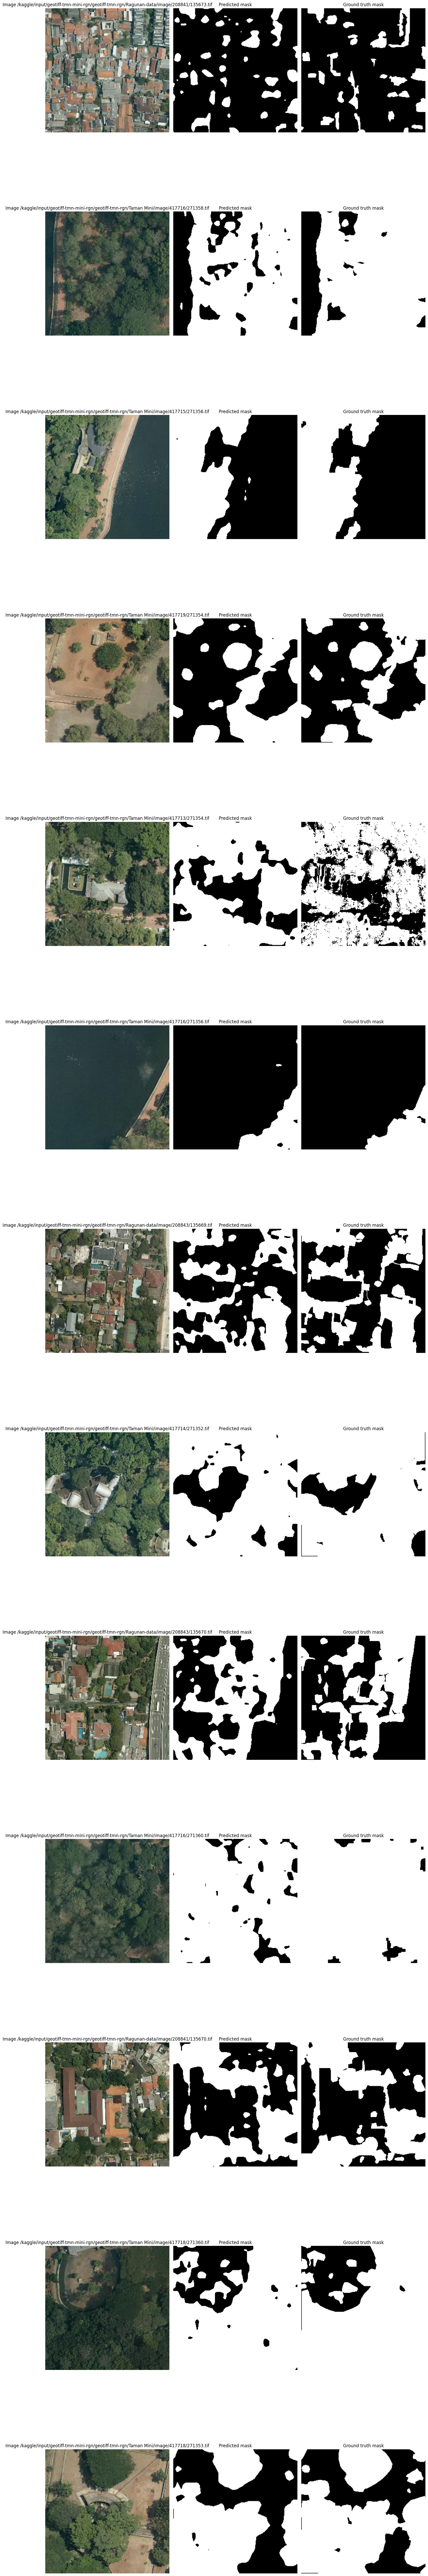

In [27]:
fine_tune_model.eval()

with torch.no_grad():
    for image, mask, image_path, mask_path in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        output = fine_tune_model(image)
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).float()

        for i in range(len(image_path)):
            img = image[i].cpu()
            if img.shape[0] == 1:
                img = img.squeeze(0).numpy()
            elif img.shape[0] == 3:
                img = img.permute(1, 2, 0).numpy()

            gt_mask = mask[i].cpu().squeeze().numpy()
            predicted_mask = pred_mask[i].cpu().squeeze().numpy()

            orig_image = Image.open(image_path[i]).convert("RGB")
            orig_image = np.array(orig_image)

            plt.figure(figsize = (15, 8))
            plt.subplot(1, 3, 1)
            plt.imshow(orig_image)
            plt.axis("off")
            plt.title(f"Image: {image_path[i]}")

            plt.subplot(1, 3, 2)
            plt.imshow(predicted_mask, cmap = "gray")
            plt.axis("off")
            plt.title("Predicted mask")

            plt.subplot(1, 3, 3)
            plt.imshow(gt_mask, cmap = "gray")
            plt.axis("off")
            plt.title("Ground truth mask")

            plt.tight_layout()
            plt.show()

In [28]:
def calculate_iou(pred_mask, gt_mask):
    intersect = np.logical_and(gt_mask > 0, pred_mask > 0).sum()
    union = np.logical_or(gt_mask > 0, pred_mask > 0).sum()
    iou = intersect / union 
    return iou

In [29]:
with torch.no_grad():
    for image, mask, image_path, mask_path in test_loader:
        image = image.to(device)
        mask = mask.to(device)
        gt_mask = mask.squeeze(1)

        output = model(image)
        output = torch.sigmoid(output)
        pred_mask = (output > 0.5).long().squeeze(1)

        for i in range(len(image_path)):
            with rasterio.open(image_path[i]) as src:
                GSD_x, GSD_y = src.res
                GSD = (GSD_x + GSD_y) / 2

            pixels = torch.sum(pred_mask[i] == 1).item()
            veg_area = pixels * (GSD ** 2)
            iou_score = calculate_iou(pred_mask[i].cpu().numpy(), gt_mask[i].cpu().numpy())
            
            print(f"Image {image_path[i]}")
            print(f"GSD: {GSD}")
            print(f"Pixels: {pixels}")
            print(f"Vegetation coverage area: {veg_area}")
            print(f"IoU score: {iou_score}")
            print("=====================================================")

Image /kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Ragunan-data/image/208841/135673.tif
GSD: 0.1
Pixels: 9326
Vegetation coverage area: 93.26000000000002
IoU score: 0.5644643460628591
Image /kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Taman Mini/image/417716/271358.tif
GSD: 0.1
Pixels: 49274
Vegetation coverage area: 492.7400000000001
IoU score: 0.9014588392310972
Image /kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Taman Mini/image/417715/271356.tif
GSD: 0.1
Pixels: 27560
Vegetation coverage area: 275.6000000000001
IoU score: 0.9589717886295288
Image /kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Taman Mini/image/417719/271354.tif
GSD: 0.1
Pixels: 26825
Vegetation coverage area: 268.25000000000006
IoU score: 0.8596051502145923
Image /kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-rgn/Taman Mini/image/417713/271354.tif
GSD: 0.1
Pixels: 50055
Vegetation coverage area: 500.5500000000001
IoU score: 0.8174778124940099
Image /kaggle/input/geotiff-tmn-mini-rgn/geotiff-tmn-